# Objective: 
Analyze ~500,000 food reviews from Amazon, using natural language processing technique Bag of words and TFIDF, and Naive Bayes ML algorithm

## data source: 
https://www.kaggle.com/snap/amazon-fine-food-reviews

1. Number of reviews: 568,454
2. Number of users: 256,059
3. Number of products: 74,258
4. Timespan: Oct 1999 - Oct 2012
5. Number of Attributes/Columns in data: 10 
6. Attribute Information:
    1. Id
    2. ProductId - unique identifier for the product
    3. UserId - unqiue identifier for the user
    4. ProfileName
    5. HelpfulnessNumerator - number of users who found the review helpful
    6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    7. Score - rating between 1 and 5
    8. Time - timestamp for the review
    9. Summary - brief summary of the review
    10. Text - text of the review
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the sqlite and pandas to read and analyse the data.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk
# nltk.download('stopwords')
import time
# import umap
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import scikitplot as skplt
import gensim
from datetime import timedelta
import os
from scipy import sparse
from prettytable import PrettyTable

In [2]:
os.chdir("data source/")

In [3]:
os.getcwd()

'C:\\Users\\kali\\Desktop\\git\\amazon-fine-food-reviews-analysis\\data source'

In [4]:
#establishing the sql connection
amazon_df_con = sql.connect('database.sqlite')

#reading the data from sql connection
amazon_df = pd.read_sql("SELECT * FROM Reviews WHERE Score!= 3", con=amazon_df_con)

print("size of our dataset is", amazon_df.shape)
amazon_df.head()

size of our dataset is (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
#lets consider every review having score greater than 3 as positive
# and less than 3 as negative 
amazon_df['Score'] = amazon_df.Score.apply(lambda x: 'Positive' if x>3 else 'Negative')

# seeing the first 5 rows of amazon_df dataframe
amazon_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
amazon_df.Score.unique()

array(['Positive', 'Negative'], dtype=object)

In [7]:
print("size of our data is", amazon_df.shape)
print("")
amazon_df.info()

size of our data is (525814, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
Id                        525814 non-null int64
ProductId                 525814 non-null object
UserId                    525814 non-null object
ProfileName               525814 non-null object
HelpfulnessNumerator      525814 non-null int64
HelpfulnessDenominator    525814 non-null int64
Score                     525814 non-null object
Time                      525814 non-null int64
Summary                   525814 non-null object
Text                      525814 non-null object
dtypes: int64(4), object(6)
memory usage: 40.1+ MB


We can see that we have total 525814 data points with 10 features

Score Feature contains two values, either Positive or Negative and it is our target variable

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

Lets see whether any duplicate observations are there in the data and delete them, so that we get unbiased results for the analysis of the data

In [8]:
# lets sort the data based on the time
amazon_df = amazon_df.sort_values('Time')

#lets drop the duplicate datpoints
amazon_df.duplicated().sum()

0

from above we can see that there are no exact duplicate observations. 
<p>
but lets see whether there are any observations having same duplicate features like Text, productId, and Time and UserId while having the remaining features different.
</p>
<p>
Because there can't be any review with same Text and UserId with different productId and also no single User can post the same review(Text) at two different times.</p>
So above subduplicates will also be considered as duplicates and we will delete them for further analysis

In [9]:
print(amazon_df.duplicated(subset=['ProductId', 'Text']).sum())
print(amazon_df.duplicated(subset=['ProductId', 'Time', 'Text']).sum())
print(amazon_df.duplicated(subset=['UserId', 'Time', 'Text']).sum())

1242
1130
161681


From above we can see that there are duplicates with same ProductId, Text, UserId
<p>
Out of the obove 3 filters, there are 161681 observations with same UserId, Time, and Text which means that same user has posted same Text at same Time, which is unlikely to happen, so lets delete the above duplicates.
</p>


In [10]:
#so there are no exact duplicate rows
#lets remove the datapoints having the same productId and Time and UserId
amazon_df = amazon_df.drop_duplicates(subset=['ProductId','Time','UserId'])
amazon_df = amazon_df.drop_duplicates(subset=['ProductId','Time','Text'])
amazon_df = amazon_df.drop_duplicates(subset=['UserId','Time','Text'])

In [11]:
amazon_df.duplicated(subset=['UserId','Time','Text']).sum()

0

Now lets see whether there are any observations which has helpfulness numerator feature greater than helpfulness denominator, and delete those observations

In [12]:
amazon_df.query('HelpfulnessNumerator>HelpfulnessDenominator')

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,Positive,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,Positive,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [13]:
# so lets remove the above two observations
num_great = amazon_df.query('HelpfulnessNumerator>HelpfulnessDenominator')
amazon_df = amazon_df.drop(num_great.index)

In [14]:
amazon_df.query('HelpfulnessNumerator>HelpfulnessDenominator')

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


In [15]:
print(amazon_df.loc[215861])
amazon_df.loc[215861]['Text']

Id                                                                   233939
ProductId                                                        B003E6COMO
UserId                                                       A2ZE58VIDDCMR7
ProfileName                                                            inna
HelpfulnessNumerator                                                      1
HelpfulnessDenominator                                                    2
Score                                                              Positive
Time                                                             1350000000
Summary                   &#1091;&#1076;&#1086;&#1073;&#1085;&#1072;&#11...
Text                      &#1056;&#1077;&#1096;&#1080;&#1083;&#1072; &#1...
Name: 215861, dtype: object


'&#1056;&#1077;&#1096;&#1080;&#1083;&#1072; &#1079;&#1072;&#1082;&#1072;&#1079;&#1072;&#1090;&#1100; &#1101;&#1090;&#1080; &#1078;&#1077;&#1083;&#1072;&#1090;&#1080;&#1085;&#1082;&#1080;, &#1090;.&#1082;. &#1076;&#1086;&#1095;&#1082;&#1072; &#1087;&#1086;&#1096;&#1083;&#1072; &#1074; &#1096;&#1082;&#1086;&#1083;&#1091; &#1080; &#1090;&#1088;&#1077;&#1073;&#1091;&#1077;&#1090; &#1089;&#1083;&#1072;&#1076;&#1086;&#1089;&#1090;&#1080;. &#1054;&#1095;&#1077;&#1085;&#1100; &#1091;&#1076;&#1086;&#1073;&#1085;&#1072;&#1103; &#1091;&#1087;&#1072;&#1082;&#1086;&#1074;&#1082;&#1072;. &#1050;&#1072;&#1082; &#1088;&#1072;&#1079; &#1089;&#1090;&#1086;&#1083;&#1100;&#1082;&#1086; &#1082;&#1086;&#1085;&#1092;&#1077;&#1090;, &#1082;&#1072;&#1082; &#1080; &#1090;&#1088;&#1077;&#1073;&#1091;&#1077;&#1090;&#1089;&#1103;, &#1095;&#1090;&#1086;&#1073;&#1099; &#1089;&#1100;&#1077;&#1089;&#1090;&#1100; &#1080;&#1093; &#1079;&#1072; &#1087;&#1077;&#1088;&#1077;&#1084;&#1077;&#1085;&#1091;.'

In [16]:
# As we can say from above that 215861 indexed row has invalid text and summary, lets drop that row also
amzon_df = amazon_df.drop(215861)

In [17]:
print("so we are left with {} observations and {} features".format(amazon_df.shape[0], amazon_df.shape[1]))

so we are left with 363960 observations and 10 features


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

In [18]:
for sent in amazon_df['Text'].values[50:52]:
    if len(re.findall('<.*?>', sent)):
        print(sent)

Long live Camper Van Beethoven!! This is a blessing for long time CVB fans who didn't have a chance to upgrade their collection to CD before most of this went out of print.  Wow, where to begin?  CVB was a band that matured on record, so to speak, so this is really a fascinating and entertaining listen from beginning to end.<br />  Of course you get the endearing and humorous debut album with goofy anthems ala "Take the Skinheads Bowling" and various folk/ska instrumentals; the increasingly warped and psychedelic "II & III"; and this collections' centerpiece: the self titled 3rd album!!  Forget the editorial remark above about them "scratching their heads out loud" on this because there's nothing confused, unfocused, or tentative about this album.  I'd say it's a characteristically irreverent and eclectic psych-rock masterpiece.  The song writing has fully matured with the sarcastic humor still intact, and it seems to be intentionally conceived as an album that gets stranger and strang

So lets import the stop words and also write functions for removing and html tags, and punctuations

In [19]:
stopw = set(stopwords.words('english'))
snow = nltk.stem.SnowballStemmer('english')
# lets remove words like not, very from stop words as they are meaninging in the reviews 
reqd_words = set(['only','very',"doesn't",'few','not'])
stopw = stopw - reqd_words

In [20]:
def clean_html(review):
    '''This function cleans html tags if any
    , in the review'''
    
    cleaner = re.compile('<.*?>')
    clean_txt  = re.sub(cleaner, ' ', review)
    return clean_txt

def cleanpunc(sentence): 
    '''function to clean the word of any punctuation
    or special characters'''
    
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stopw)
print('****************************')
print(snow.stem('beautiful'))

{'too', "couldn't", 'won', 'nor', 'theirs', 'doing', 're', 'shan', 'himself', 'out', "didn't", 'these', "hasn't", 'was', "should've", 'i', 'your', 'wouldn', 'before', 'ours', 'isn', 'after', 'mustn', 'or', 'can', 'shouldn', 'into', 'there', 'where', 'their', 'have', 'yourself', 'what', 'over', 'those', 'itself', "haven't", 'because', 'above', 'who', 'from', 'herself', 'under', 'but', 'my', 'own', 'had', 'each', 'which', 'how', "shan't", "isn't", "needn't", 'couldn', 'hasn', 'any', "don't", 'against', 'both', 'through', 'other', 'should', 'a', 'she', 've', 'll', 'at', 'they', 'again', 'most', "you'll", 't', 'didn', 'to', 'needn', "weren't", 'now', 'ma', 'be', 'its', "you've", 'up', 'ain', 'that', 'why', 'hadn', 'haven', 'between', 'here', 'do', 'off', 'he', 'been', 'aren', "mustn't", 'yours', 'about', 'for', 'weren', 'his', 'did', 'them', 'yourselves', 'so', 'ourselves', 'as', 'then', 'him', 'o', 'and', "wasn't", 'themselves', 'further', "that'll", "she's", 'during', 'her', 'whom', 'unt

To analyze the reviews and convert to vectors lets perform the following steps

1. iterating through each of the review(# 1st loop)
2. cleaning any html content of the review 
3. splitting individually all the words of the review into a list 
4. apply cleanpunc function on each word of the list so that we can remove if any punctiations are there
5. checking whether the cleaned word is there in the stop words
6. add the word to the new list if the cleaned word is not the stop words, and it is alphabetic and length is greater than 2
7. Separately store all the positve words and negative words in two separate lists
8. now make whole new list into a string
9. the new string is the processed review

final_cleaned_reviews = []
all_positive_words = []
all_negative_words = []
start_time = time.time()
for i,review in enumerate(amazon_df['Text'].values):
    review_filtered_words = []
    html_free = clean_html(review)
    for h_free_word in html_free.split():
        for clean_word in cleanpunc(h_free_word).split():
            if (((clean_word.isalpha()) & (len(clean_word)>2)) & \
                ((clean_word.lower() not in stopw))):
                final_word = snow.stem(clean_word.lower())
                review_filtered_words.append(final_word)
                if amazon_df['Score'].values[i] == 'Positive':
                    all_positive_words.append(final_word)
                else:
                    all_negative_words.append(final_word)
    final_str = " ".join(review_filtered_words)
    final_cleaned_reviews.append(final_str)
end_time = time.time()
print('time took is ', (end_time-start_time))

In [25]:
def clean_text(list_of_texts):
    final_cleaned_reviews = []
    all_positive_words = []
    all_negative_words = []
    start_time = time.time()
    for i,review in enumerate(list_of_texts.values):
        review_filtered_words = []
        html_free = clean_html(review)
        for h_free_word in html_free.split():
            for clean_word in cleanpunc(h_free_word).split():
                if (((clean_word.isalpha()) & (len(clean_word)>2)) & \
                    ((clean_word.lower() not in stopw))):
                    final_word = snow.stem(clean_word.lower())
                    review_filtered_words.append(final_word)
                    if amazon_df['Score'].values[i] == 'Positive':
                        all_positive_words.append(final_word)
                    else:
                        all_negative_words.append(final_word)
        final_str = " ".join(review_filtered_words)
        final_cleaned_reviews.append(final_str)
    end_time = time.time()
    print('time took is ', (end_time-start_time))
    return final_cleaned_reviews

In [28]:
final_cleaned_reivews = clean_text(amazon_df.Text)

time took is  752.3294124603271


In [30]:
%%time
# adding the cleaned reviews to dataframe
amazon_df['CleanedText']=final_cleaned_reivews

Wall time: 60.4 ms


In [31]:
# now lets clean our Summary column and append it our dataframe
final_cleaned_summary = clean_text(amazon_df.Summary)

time took is  66.95469236373901


In [33]:
amazon_df['Cleaned_summary'] = final_cleaned_summary
len(final_cleaned_summary)

363960

In [34]:
amazon_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_summary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,Positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,Positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,Positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,Positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


Positive    0.843164
Negative    0.156836
Name: Score, dtype: float64


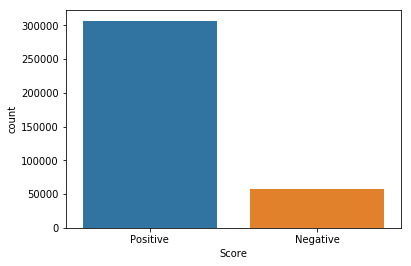

In [35]:
print(amazon_df.Score.value_counts(normalize=True))
sns.countplot(amazon_df.Score);

we can see that there are 84.31 percent positive reviews and 15.68 percent negative reviews, 
<br>
So the amazon fine food reviews dataset is higly imbalanced with postive reviews
</br>
#### Since the dataset is higly imbalanced accuracy is not a good performance metric</li>

#### So we will use ROC AUC, confusion matrix, and precision recall and f1 scores for evaluation of our models</li>

In [36]:
# Now lets split the dataset into train, validation and test dataset
train_df = amazon_df[:120000]
cv_df = amazon_df[120000:160000]
test_df = amazon_df[160000:200000]

In [37]:
train_df.shape, test_df.shape, cv_df.shape

((120000, 12), (40000, 12), (40000, 12))

# [4] Featurization

## [4.1] BAG OF WORDS

### converting text into vectors using BOW unigram

In [38]:
count_vect = CountVectorizer(min_df=10, max_features=10000)
unigram_xtrain_vect = count_vect.\
fit_transform(train_df.CleanedText)

unigram_xtest_vect = count_vect.transform(test_df.CleanedText)

unigram_xcv_vect = count_vect.transform(cv_df.CleanedText)

In [39]:
print(unigram_xtrain_vect.shape, unigram_xcv_vect.shape, unigram_xtest_vect.shape)

(120000, 9140) (40000, 9140) (40000, 9140)


## [4.2] Bi-Grams

### converting data into vectors using BOW bigram

In [40]:
bigram_count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=10000)
bigram_xtrain_vect = bigram_count_vect.\
fit_transform(train_df.CleanedText)

bigram_xtest_vect = bigram_count_vect.transform(test_df.CleanedText)

bigram_xcv_vect = bigram_count_vect.transform(cv_df.CleanedText)

In [41]:
bigram_xtrain_vect.shape, bigram_xcv_vect.shape, bigram_xtest_vect.shape

((120000, 10000), (40000, 10000), (40000, 10000))

## [4.3] Tri-Grams

### converting data into vectors using BOW trigrams

In [42]:
trigram_count_vect = CountVectorizer(ngram_range=(1,3), min_df=10, max_features=10000)
trigram_xtrain_vect = trigram_count_vect.\
fit_transform(train_df.CleanedText)

trigram_xtest_vect = trigram_count_vect.transform(test_df.CleanedText)

trigram_xcv_vect = trigram_count_vect.transform(cv_df.CleanedText)

In [43]:
trigram_xtrain_vect.shape, trigram_xcv_vect.shape, trigram_xtest_vect.shape

((120000, 10000), (40000, 10000), (40000, 10000))

## [4.4] TF-IDF

### converting data into vectors using TF-IDF unigram

In [44]:
tfidf_uni = TfidfVectorizer(min_df=10, max_features=10000)
tfidf_uni_xtrain_vect = tfidf_uni.\
fit_transform(train_df.CleanedText)

tfidf_uni_xtest_vect = tfidf_uni.transform(test_df.CleanedText)

tfidf_uni_xcv_vect = tfidf_uni.transform(cv_df.CleanedText)

In [45]:
print(tfidf_uni_xtrain_vect.shape, tfidf_uni_xcv_vect.shape, tfidf_uni_xtest_vect.shape)

(120000, 9140) (40000, 9140) (40000, 9140)


### converting data into vectors using TF-IDF bigram

In [46]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=10000)
tfidf_xtrain_vect = tfidf.\
fit_transform(train_df.CleanedText)

tfidf_xtest_vect = tfidf.transform(test_df.CleanedText)

tfidf_xcv_vect = tfidf.transform(cv_df.CleanedText)

In [47]:
print(tfidf_xtrain_vect.shape, tfidf_xcv_vect.shape, tfidf_xtest_vect.shape)

(120000, 10000) (40000, 10000) (40000, 10000)


### converting data into vectors using TF-IDF trigram

In [123]:
tfidf_tri = TfidfVectorizer(ngram_range=(1,3), min_df=10, max_features=10000)
tfidf_tri_xtrain_vect = tfidf_tri.\
fit_transform(train_df.CleanedText)

tfidf_tri_xtest_vect = tfidf_tri.transform(test_df.CleanedText)

tfidf_tri_xcv_vect = tfidf_tri.transform(cv_df.CleanedText)

In [49]:
print(tfidf_tri_xtrain_vect.shape, tfidf_tri_xcv_vect.shape, tfidf_tri_xtest_vect.shape)

(120000, 10000) (40000, 10000) (40000, 10000)


# Applying Multinomial Naive Bayes

Lets write a function which does the following things using Multinomial Naive Bayes:
<ol>
    <li> find the optimal alpha using the train and validation dataset </li>
    <li> Plotting the confusion matrix and precision recall f1 score on validation dataset</li>
    <li> plot the ROC AUC curve using optimal alpha on validation dataset </li>
    <li> Fit the Multinomial Naive Bayes on train dataset using optmial alpha
        and Predict on test dataset</li> 
    <li> Plot the confusion matrix, precision recall values </li>
    <li> Plot the ROC AUC curve on test dataset values</li>
</ol>

In [50]:
def mnb_model(x_train, y_train, x_cv, y_cv, x_test, y_test):
    '''this function uses the validation dataset to find the optimal k 
    and uses the optimal k and trained algorithm to predict the test data'''
    
    ##finding the optimal alpha using validation dataset
    print('------------------------------------------------------------')
    print('started finding the optimal alpha for MultinomialNB algorithm')
    alpha_values = list(np.logspace(np.log(0.00005), np.log(10000), base = np.exp(1), num = 20))
    train_auc = []
    auc = []
    best_cv_predict = 0
    best_fpr = 0
    best_tpr= 0
    for a in alpha_values:
        mnb = MultinomialNB(alpha=a)
        mnb.fit(x_train, y_train)
        #cv_predict = knn.predict(x_cv)
        #if you have enough ram run above code otherwise run below
        predicted_labels = []
        predicted_prob = []
        train_predicted_labels = []
        train_predicted_prob = []
        
        for i in range(0, x_cv.shape[0], 500):
            predicted_labels.extend(mnb.predict(x_cv[i:i+500]))
            predicted_prob.extend(mnb.predict_proba(x_cv[i:i+500]))
            
        for i in range(0, x_train.shape[0], 500):
            train_predicted_labels.extend(mnb.predict(x_train[i:i+500]))
            train_predicted_prob.extend(mnb.predict_proba(x_train[i:i+500]))
            
        cv_predict = np.array(predicted_labels)
        cv_predict_proba = np.array(predicted_prob)
        train_predict = np.array(train_predicted_labels)
        train_predict_proba = np.array(train_predicted_prob)
        
        fpr, tpr, thresholds = metrics.roc_curve(y_cv, [x[1] for x in predicted_prob], pos_label='Positive')
        t_fpr, t_tpr, t_thresholds = metrics.roc_curve(y_train, [x[1] for x in train_predict_proba], pos_label='Positive')
        auc_score = metrics.auc(fpr, tpr)
        t_auc_score = metrics.auc(t_fpr, t_tpr)
        #acc_score = accuracy_score(y_cv, cv_predict)
        auc.append(auc_score)
        train_auc.append(t_auc_score)
        if auc_score >= max(auc):
            best_cv_predict = cv_predict
            best_cv_predict_proba = cv_predict_proba
            best_fpr = fpr
            best_tpr = tpr
            print('as of now best alpha is {} with AUC score of {}'.format(a, auc_score))
        
    plt.figure(figsize=(16,4))
    plt.plot(np.log(alpha_values), auc, label='validation AUC');
    plt.plot(np.log(alpha_values), train_auc, label='train AUC');
    plt.xticks(np.log(alpha_values));
    plt.xlabel("log(alpha values)")
    plt.ylabel("auc score")
    plt.legend();
    plt.title('auc score on train dataset and validation dataset with different alpha values');
    plt.show()    
    
    optimal_alpha = alpha_values[auc.index(max(auc))]
    print('alpha value which is giving highest AUC value of {} on cross vadiation dataset is {}'.format(max(auc), optimal_alpha))
    
    # AUC curve on this optimal alpha value on crossvalidation dataset
    # ROC AUC PLOT
    print('ROC plot with best alpha value on cross validation dataset')
    skplt.metrics.plot_roc(y_cv, best_cv_predict_proba, title='ROC Curves on validation dataset')
    plt.show()
    
    #confusion matrix of this optimal neighbour on crossvalidation dataset
    cv_cm = pd.crosstab(y_cv, best_cv_predict, rownames=["actual Score"], colnames=["predicted Score"], normalize=True)
    sns.heatmap(cv_cm, annot=True, fmt=".4f")
    plt.title('Confusion matrix on validation dataset with best parameters');
    plt.show()
    
    print('precission recall and f score on best optimal alpha predicted data of validation dataset is')
    print(classification_report(y_cv, best_cv_predict))
    print('------------------------------------------------------------------------------')
    
    # trainning the algorithm on train data+validation data and testing on the test data
    print('training the algoritm using train data + validation data and predicting on the test dataset')
    x_train_valid = sparse.vstack((x_train, x_cv))
    y_train_valid = np.hstack((y_train, y_cv))
    t_mnb = MultinomialNB(alpha=optimal_alpha)
    t_mnb.fit(x_train_valid, y_train_valid)
    #test_predict = knn.predict(x_test)
    
    predicted_list = []
    predicted_prob_list = []
    for i in range(0, x_test.shape[0], 500):
        predicted_list.extend(t_mnb.predict(x_test[i:i+500]))
        predicted_prob_list.extend(t_mnb.predict_proba(x_test[i:i+500]))
        
            
    test_predict = np.array(predicted_list)
    test_predict_proba = np.array(predicted_prob_list)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, [x[1] for x in predicted_prob_list], pos_label='Positive')
    auc_score = metrics.auc(fpr, tpr)
    
    #print('accuracy score on test data is {}'.format(accuracy_score(y_test, test_predict)))
    print('AUC score on test data is {}'.format(auc_score))
    
    #ROC plot on test dataset
    skplt.metrics.plot_roc(y_test, test_predict_proba, title='ROC Curves on test dataset') 
    plt.show()
    
    #confusion matrix on test dataset
    test_cm = pd.crosstab(y_test, test_predict, rownames=["actual Score"], colnames=["predicted Score"], normalize=True)
    sns.heatmap(test_cm, annot=True, fmt=".4f")
    plt.title('Confusion matrix on test dataset with best parameters');
    plt.show()
    
    print('precission recall and f score using best optimal alpha predicted data on test dataset is')
    print(classification_report(y_test, test_predict))
    return t_mnb.feature_log_prob_

## [5.1] Applying Naive Bayes on BOW unigram,<font color='red'> SET 1</font>

------------------------------------------------------------
started finding the optimal alpha for MultinomialNB algorithm
as of now best alpha is 5.000000000000007e-05 with AUC score of 0.8979668261607996
as of now best alpha is 0.00013673078900308913 with AUC score of 0.8998645187447889
as of now best alpha is 0.00037390617322814436 with AUC score of 0.9018673468350022
as of now best alpha is 0.0010224897215721964 with AUC score of 0.9039663936537986
as of now best alpha is 0.0027961165275623007 with AUC score of 0.9061572942175394
as of now best alpha is 0.007646304379163406 with AUC score of 0.9083934917383161
as of now best alpha is 0.02090970461441573 with AUC score of 0.9105694656982999
as of now best alpha is 0.057180008195011796 with AUC score of 0.9125634316870765
as of now best alpha is 0.15636535271414095 with AUC score of 0.9143365103670822
as of now best alpha is 0.4275991609870157 with AUC score of 0.9157761895008711
as of now best alpha is 1.169319413176268 with AUC sco

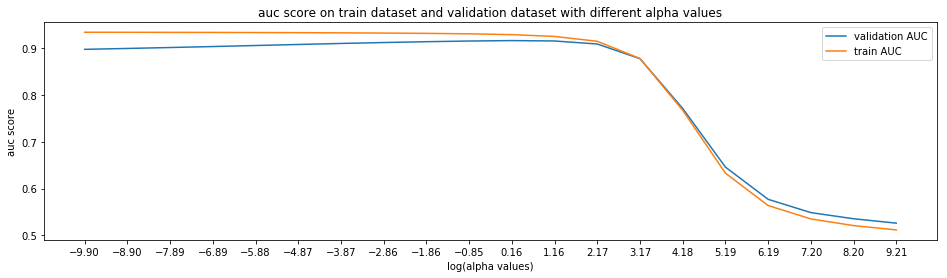

alpha value which is giving highest AUC value of 0.9167118018732651 on cross vadiation dataset is 1.169319413176268
ROC plot with best alpha value on cross validation dataset


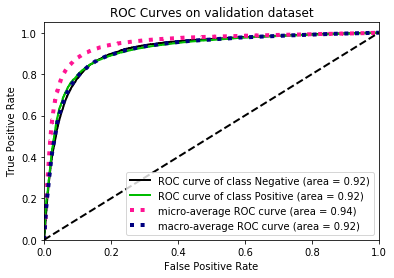

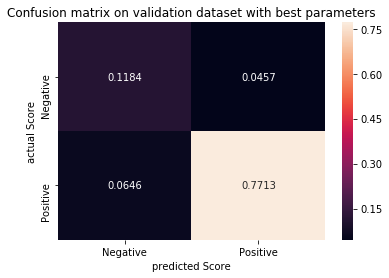

precission recall and f score on best optimal alpha predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.65      0.72      0.68      6564
    Positive       0.94      0.92      0.93     33436

   micro avg       0.89      0.89      0.89     40000
   macro avg       0.80      0.82      0.81     40000
weighted avg       0.90      0.89      0.89     40000

------------------------------------------------------------------------------
training the algoritm using train data + validation data and predicting on the test dataset
AUC score on test data is 0.9179703729869104


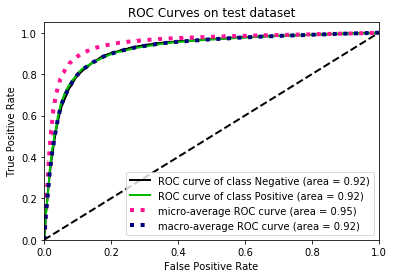

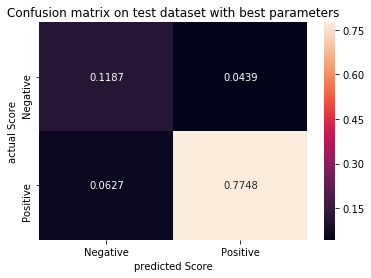

precission recall and f score using best optimal alpha predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.65      0.73      0.69      6501
    Positive       0.95      0.93      0.94     33499

   micro avg       0.89      0.89      0.89     40000
   macro avg       0.80      0.83      0.81     40000
weighted avg       0.90      0.89      0.90     40000

Wall time: 54.2 s


In [51]:
%%time
unigram_feature_log_probs = mnb_model(x_train=unigram_xtrain_vect, y_train=train_df.Score, x_cv=unigram_xcv_vect, y_cv=cv_df.Score, x_test=unigram_xtest_vect, y_test=test_df.Score)

## Observation:
1. We are getting an AUC score of  0.916 on validation data set and 0.917 AUC score on test datset with optimal alpha of 1.169319413176268 using Multinomial Naive bayes algorithm and Bag of words unigram vectorizer.
2. Clearly from the above figures and AUC scores we can say that our model is not over fitting.
3. our model predicted 4.39% negative reviews as positive reviews.
4. our model predicted 6.27% positive reviews as negative reviews.
5. recall value on negative reviews is 73%, whereas recall value on positive reviews is 93%, so our model is using most of the actual values from positive reviews compared to negative reviews.
6. Our model is more precise(95% precision) in predicting positive reviews than comapared to negative reivews(65% precision)

In [52]:
output = PrettyTable()
output.field_names = ['Vectorizer', 'Model', 'Feature engineered','Hyper Parameter', 'Test AUC', 'Test micro avg F1-score']

In [53]:
output.add_row(['BOW unigram', 'Multinomial Naive bayes', 'NO', 'alpha = 1.169319413176268', 0.917, 0.89])

### [5.1.1] Top 10 important features of positive class from unigram<font color='red'> SET 1</font>

In [54]:
sorted(zip(unigram_feature_log_probs[1], count_vect.get_feature_names()), reverse=True)[:10]

[(-4.4028233116138935, 'not'),
 (-4.463192532875128, 'like'),
 (-4.5175592919845915, 'tast'),
 (-4.650817416084774, 'good'),
 (-4.6743098230967455, 'flavor'),
 (-4.716264119200748, 'great'),
 (-4.716976328910661, 'love'),
 (-4.75041033301375, 'use'),
 (-4.763895147234276, 'tea'),
 (-4.80585368705006, 'one')]

### [5.1.2] Top 10 important features of negative class from unigram <font color='red'> SET 1</font>

In [55]:
sorted(zip(unigram_feature_log_probs[0], count_vect.get_feature_names()), reverse=True)[:10]

[(-3.824548378137882, 'not'),
 (-4.236342116176788, 'tast'),
 (-4.330486984106276, 'like'),
 (-4.464847677723201, 'product'),
 (-4.748698194622836, 'one'),
 (-4.8074532401504655, 'flavor'),
 (-4.922843136931647, 'tri'),
 (-4.934328536773711, 'veri'),
 (-4.939815377390625, 'would'),
 (-5.042578265241971, 'good')]

## [5.2] Applying Naive Bayes on bigram,<font color='red'> SET 1</font>

------------------------------------------------------------
started finding the optimal alpha for MultinomialNB algorithm
as of now best alpha is 5.000000000000007e-05 with AUC score of 0.9351757897376265
as of now best alpha is 0.00013673078900308913 with AUC score of 0.9354987210689067
as of now best alpha is 0.00037390617322814436 with AUC score of 0.9358233177462412
as of now best alpha is 0.0010224897215721964 with AUC score of 0.9361362159940435
as of now best alpha is 0.0027961165275623007 with AUC score of 0.9364210516800211
as of now best alpha is 0.007646304379163406 with AUC score of 0.9366787497432951
as of now best alpha is 0.02090970461441573 with AUC score of 0.9368993203857165
as of now best alpha is 0.057180008195011796 with AUC score of 0.9370868506535519
as of now best alpha is 0.15636535271414095 with AUC score of 0.9372367887527986
as of now best alpha is 0.4275991609870157 with AUC score of 0.9373273462160677


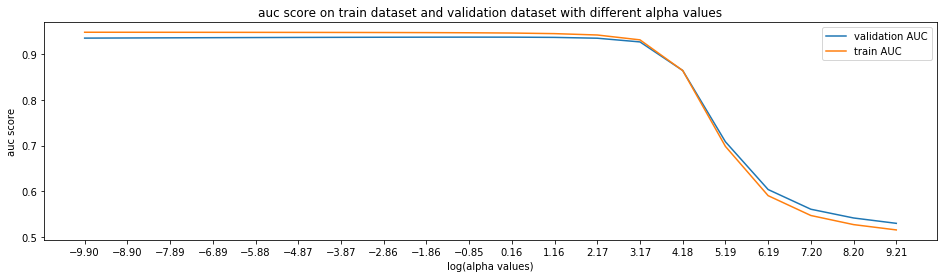

alpha value which is giving highest AUC value of 0.9373273462160677 on cross vadiation dataset is 0.4275991609870157
ROC plot with best alpha value on cross validation dataset


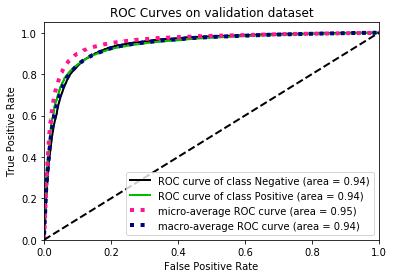

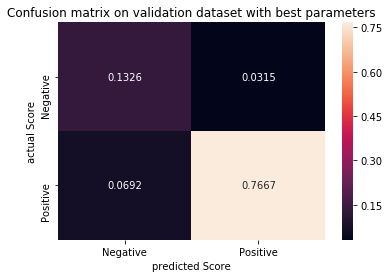

precission recall and f score on best optimal alpha predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.66      0.81      0.72      6564
    Positive       0.96      0.92      0.94     33436

   micro avg       0.90      0.90      0.90     40000
   macro avg       0.81      0.86      0.83     40000
weighted avg       0.91      0.90      0.90     40000

------------------------------------------------------------------------------
training the algoritm using train data + validation data and predicting on the test dataset
AUC score on test data is 0.939338621338978


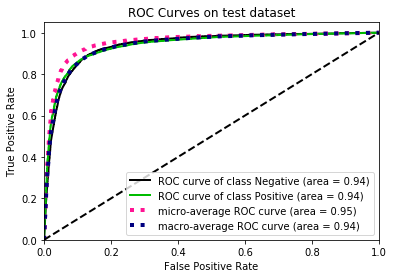

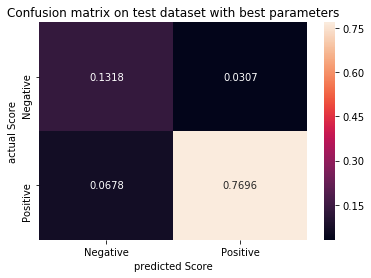

precission recall and f score using best optimal alpha predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.66      0.81      0.73      6501
    Positive       0.96      0.92      0.94     33499

   micro avg       0.90      0.90      0.90     40000
   macro avg       0.81      0.86      0.83     40000
weighted avg       0.91      0.90      0.91     40000

Wall time: 57.2 s


In [56]:
%%time
bigram_feature_log_probs = mnb_model(x_train=bigram_xtrain_vect, y_train=train_df.Score, x_cv=bigram_xcv_vect, y_cv=cv_df.Score, x_test=bigram_xtest_vect, y_test=test_df.Score)

## Observation:
1. We are getting an AUC score of  0.937 on validation data set and 0.939 AUC score on test datset with optimal alpha of 0.4275991609870157 using Multinomial Naive bayes algorithm and Bag of words unigram vectorizer.
2. There is a increase of 2% of AUC score by using BOW bigrams, rather than unigrams
3. Clearly from the above figures and AUC scores we can say that our model is not over fitting.
4. bigram model predicted only 3.07 negative reviews as positive reviews, compared to 4.39% of unigrams. 
5. So by using bigrams false positive rate has decreased by 1%.
6. our model predicted 6.78% positive reviews as negative reviews compared to 6.27% of unigrams.
7. So by using bigrams false negative rate has increased by 0.5%.
5. recall value on negative reviews is 81% compared to 73% of unigrams, whereas recall value on positive reviews is 92 compared to 93% of unigrams, so our bigrams model is still using most of the actual values from positive reviews compared to negative reviews. but definitely better than unigrams
6. So bigram MNB model has increased the recall rate on negative reviews by 8%, and decreased the recall rate on positive reviews by 1%. So considering the increase of 8% recall rate compared to 1% decrease of recall rate on positive, we can say bigram model is good in using most of the actual values of positive and negative reviews compared to unigram model.
7. bigram model is more precise(96% precision) in predicting positive reviews than comapared to negative reivews(66% precision)
8. Bigram model increased both the positve and negative reviews precision by 1% when compared with unigram model
9. So from the above analysis we can say that our BOW bigram model is better when compared with unigram model.

In [57]:
output.add_row(['BOW bigram', 'Multinomial Naive bayes', 'NO', 'alpha = 0.4275991609870157', 0.939, 0.90])

### [5.2.1] Top 10 important features of positive class from bigram<font color='red'> SET 1</font>

In [58]:
sorted(zip(bigram_feature_log_probs[1], bigram_count_vect.get_feature_names()), reverse=True)[:10]

[(-4.5930928714593335, 'not'),
 (-4.65346282058349, 'like'),
 (-4.707830273869471, 'tast'),
 (-4.841090267965983, 'good'),
 (-4.8645830312663705, 'flavor'),
 (-4.9065379848529975, 'great'),
 (-4.907250205964068, 'love'),
 (-4.940684754525359, 'use'),
 (-4.954169793543988, 'tea'),
 (-4.996129052537425, 'one')]

### [5.2.2] Top 10 important features of negative class from bigram<font color='red'> SET 1</font>

In [59]:
sorted(zip(bigram_feature_log_probs[0], bigram_count_vect.get_feature_names()), reverse=True)[:10]

[(-3.978394146280854, 'not'),
 (-4.390206820036974, 'tast'),
 (-4.484357226098577, 'like'),
 (-4.6187267836723045, 'product'),
 (-4.902600442301917, 'one'),
 (-4.961361154903363, 'flavor'),
 (-5.076763198960441, 'tri'),
 (-5.088249886376632, 'veri'),
 (-5.093737347337445, 'would'),
 (-5.196512505227446, 'good')]

## [5.3] Applying Naive Bayes on trigram,<font color='red'> SET 1</font>

------------------------------------------------------------
started finding the optimal alpha for MultinomialNB algorithm
as of now best alpha is 5.000000000000007e-05 with AUC score of 0.9354568687127377
as of now best alpha is 0.00013673078900308913 with AUC score of 0.9357590595372105
as of now best alpha is 0.00037390617322814436 with AUC score of 0.9360607172686917
as of now best alpha is 0.0010224897215721964 with AUC score of 0.9363533078629704
as of now best alpha is 0.0027961165275623007 with AUC score of 0.9366221256992813
as of now best alpha is 0.007646304379163406 with AUC score of 0.9368696949957205
as of now best alpha is 0.02090970461441573 with AUC score of 0.9370867663610705
as of now best alpha is 0.057180008195011796 with AUC score of 0.9372758366753251
as of now best alpha is 0.15636535271414095 with AUC score of 0.9374265903612851
as of now best alpha is 0.4275991609870157 with AUC score of 0.9375170134122187


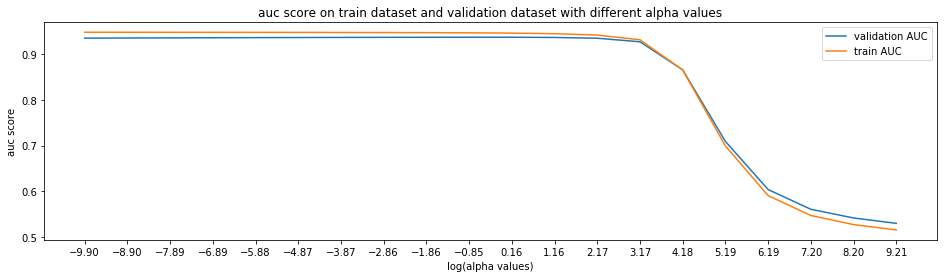

alpha value which is giving highest AUC value of 0.9375170134122187 on cross vadiation dataset is 0.4275991609870157
ROC plot with best alpha value on cross validation dataset


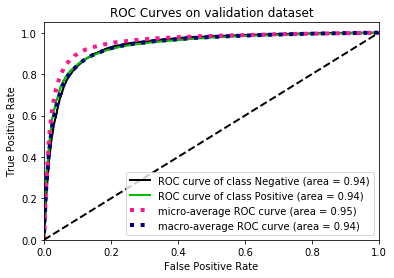

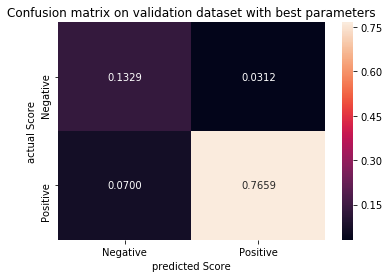

precission recall and f score on best optimal alpha predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.66      0.81      0.72      6564
    Positive       0.96      0.92      0.94     33436

   micro avg       0.90      0.90      0.90     40000
   macro avg       0.81      0.86      0.83     40000
weighted avg       0.91      0.90      0.90     40000

------------------------------------------------------------------------------
training the algoritm using train data + validation data and predicting on the test dataset
AUC score on test data is 0.9398757510658873


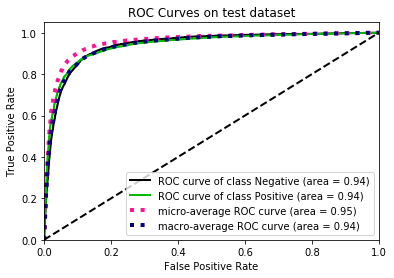

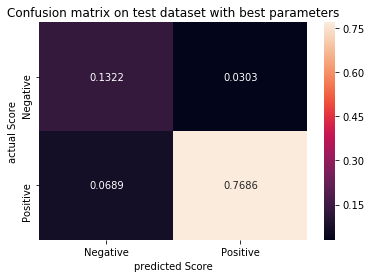

precission recall and f score using best optimal alpha predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.66      0.81      0.73      6501
    Positive       0.96      0.92      0.94     33499

   micro avg       0.90      0.90      0.90     40000
   macro avg       0.81      0.87      0.83     40000
weighted avg       0.91      0.90      0.90     40000

Wall time: 50.8 s


In [60]:
%%time
trigram_feature_log_probs = mnb_model(x_train=trigram_xtrain_vect, y_train=train_df.Score, x_cv=trigram_xcv_vect, y_cv=cv_df.Score, x_test=trigram_xtest_vect, y_test=test_df.Score)

## Observation:
1. We can see that the test auc score, optimal alpha and micro avg f1 score and every other values of trigram are same as BOW bigram values.
2. So considering we are tokenizing 3 grams, compared to bigrams and still getting the same performance, I am considering bigram as the best model till now.

In [61]:
output.add_row(['BOW trigram', 'Multinomial Naive bayes', 'NO', 'alpha = 0.4275991609870157', 0.939, 0.90])

### [5.3.1] Top 10 important features of positive class from trigram<font color='red'> SET 1</font>

In [62]:
sorted(zip(trigram_feature_log_probs[1], trigram_count_vect.get_feature_names()), reverse=True)[:10]

[(-4.596870432789137, 'not'),
 (-4.657240381913294, 'like'),
 (-4.711607835199274, 'tast'),
 (-4.8448678292957865, 'good'),
 (-4.868360592596174, 'flavor'),
 (-4.910315546182801, 'great'),
 (-4.911027767293872, 'love'),
 (-4.944462315855162, 'use'),
 (-4.957947354873792, 'tea'),
 (-4.999906613867228, 'one')]

### [5.3.2] Top 10 important features of negative class from trigram<font color='red'> SET 1</font>

In [63]:
sorted(zip(trigram_feature_log_probs[0], trigram_count_vect.get_feature_names()), reverse=True)[:10]

[(-3.9792677314540903, 'not'),
 (-4.391080405210211, 'tast'),
 (-4.485230811271814, 'like'),
 (-4.619600368845541, 'product'),
 (-4.903474027475154, 'one'),
 (-4.9622347400766, 'flavor'),
 (-5.077636784133677, 'tri'),
 (-5.089123471549868, 'veri'),
 (-5.094610932510681, 'would'),
 (-5.197386090400682, 'good')]

## [5.4] Applying Naive Bayes on TFIDF unigram,<font color='red'> SET 1</font>

------------------------------------------------------------
started finding the optimal alpha for MultinomialNB algorithm
as of now best alpha is 5.000000000000007e-05 with AUC score of 0.9020638326094568
as of now best alpha is 0.00013673078900308913 with AUC score of 0.9044505582768511
as of now best alpha is 0.00037390617322814436 with AUC score of 0.9071063819961028
as of now best alpha is 0.0010224897215721964 with AUC score of 0.9100082076272721
as of now best alpha is 0.0027961165275623007 with AUC score of 0.9131045074042152
as of now best alpha is 0.007646304379163406 with AUC score of 0.916291633469098
as of now best alpha is 0.02090970461441573 with AUC score of 0.9194818077323672
as of now best alpha is 0.057180008195011796 with AUC score of 0.9225969707997722
as of now best alpha is 0.15636535271414095 with AUC score of 0.9251939173597604
as of now best alpha is 0.4275991609870157 with AUC score of 0.9258548524292893


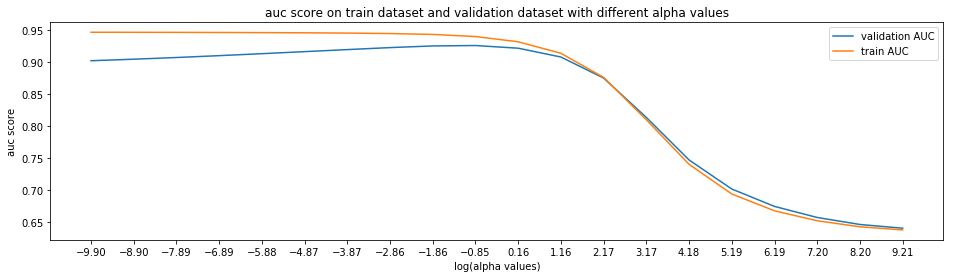

alpha value which is giving highest AUC value of 0.9258548524292893 on cross vadiation dataset is 0.4275991609870157
ROC plot with best alpha value on cross validation dataset


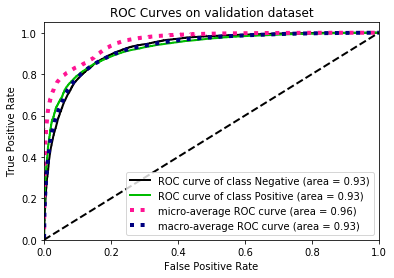

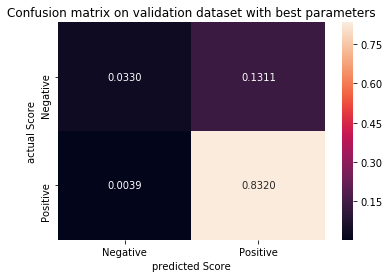

precission recall and f score on best optimal alpha predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.89      0.20      0.33      6564
    Positive       0.86      1.00      0.92     33436

   micro avg       0.87      0.87      0.87     40000
   macro avg       0.88      0.60      0.63     40000
weighted avg       0.87      0.87      0.83     40000

------------------------------------------------------------------------------
training the algoritm using train data + validation data and predicting on the test dataset
AUC score on test data is 0.9273023938584075


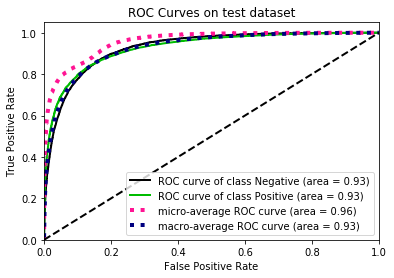

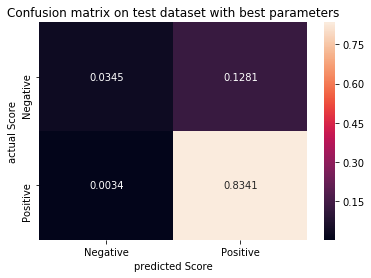

precission recall and f score using best optimal alpha predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.91      0.21      0.34      6501
    Positive       0.87      1.00      0.93     33499

   micro avg       0.87      0.87      0.87     40000
   macro avg       0.89      0.60      0.64     40000
weighted avg       0.87      0.87      0.83     40000

Wall time: 2min 9s


In [64]:
%%time
tfidf_uni_feature_log_probs = mnb_model(x_train=tfidf_uni_xtrain_vect, y_train=train_df.Score, x_cv=tfidf_uni_xcv_vect, y_cv=cv_df.Score, x_test=tfidf_uni_xtest_vect, y_test=test_df.Score)

## Observation:
1. We are getting an AUC score of  0.925 on validation data set and 0.927 AUC score on test datset with optimal alpha of 0.4275991609870157 using Multinomial Naive bayes algorithm and Bag of words unigram vectorizer.
2. Only 0.012 score is less than bigram AUC(0.939)
3. Clearly from the above figures and AUC scores we can say that our model is not over fitting.
4. TFIDF unigram model predicted 12.81% negative reviews as positive reviews, compared to 3.07% of bigrams. 
5. So by using TFIDF unigram false positive rate has increased by 9.7%, which is not good
6. our model predicted 0.34% positive reviews as negative reviews compared to 6.78% of bigrams.
7. So by using TFIDF false negative rate has decreased by 6.4% compared to bigrams.
5. recall value on negative reviews is 21% compared to 81% of bigrams, whereas recall value on positive reviews is 100% compared to 92% of bigrams, so our TFIDF model is using most of the actual values from positive reviews compared to negative reviews. 
6. So TFIDF ungiram model has decreased the recall rate on negative reviews by 60%, and increased the recall rate on positive reviews by 8%. 
7. Even though recall on positive rate is increased to 100% we can't say TFIDF is good model, as recall on negative reviews is only 27%, so TFIDF model is not considered as best model when compared to BOW bigram model.
7. TFIDF model is less precise(87% precision) in predicting positive reviews than comapared to negative reivews(91% precision)
9. So from the above analysis we can say that still BOW bigram model is better when compared with TFIDF unigram

In [66]:
output.add_row(['TFIDF unigram', 'Multinomial Naive bayes', 'NO', 'alpha = 0.4275991609870157', 0.927, 0.87])

## [5.5] Applying Naive Bayes on TFIDF bigram,<font color='red'> SET 2</font>

------------------------------------------------------------
started finding the optimal alpha for MultinomialNB algorithm
as of now best alpha is 5.000000000000007e-05 with AUC score of 0.9468888519885261
as of now best alpha is 0.00013673078900308913 with AUC score of 0.9472366518800339
as of now best alpha is 0.00037390617322814436 with AUC score of 0.9475749244429534
as of now best alpha is 0.0010224897215721964 with AUC score of 0.9478991862285369
as of now best alpha is 0.0027961165275623007 with AUC score of 0.948208494072261
as of now best alpha is 0.007646304379163406 with AUC score of 0.9485021235144202
as of now best alpha is 0.02090970461441573 with AUC score of 0.9487876973291549
as of now best alpha is 0.057180008195011796 with AUC score of 0.9490846665761228
as of now best alpha is 0.15636535271414095 with AUC score of 0.9493775852276268
as of now best alpha is 0.4275991609870157 with AUC score of 0.9494671220684169


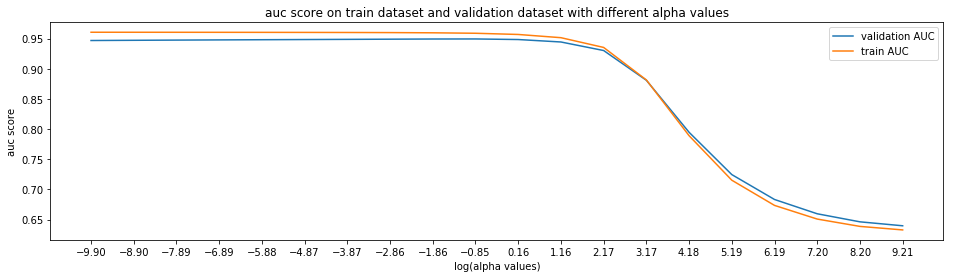

alpha value which is giving highest AUC value of 0.9494671220684169 on cross vadiation dataset is 0.4275991609870157
ROC plot with best alpha value on cross validation dataset


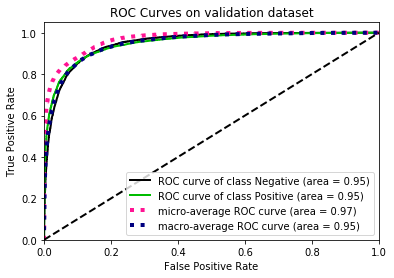

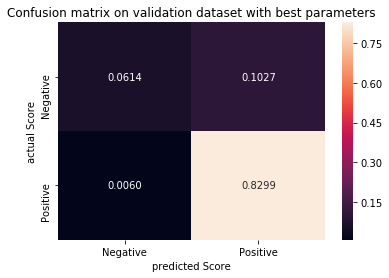

precission recall and f score on best optimal alpha predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.91      0.37      0.53      6564
    Positive       0.89      0.99      0.94     33436

   micro avg       0.89      0.89      0.89     40000
   macro avg       0.90      0.68      0.73     40000
weighted avg       0.89      0.89      0.87     40000

------------------------------------------------------------------------------
training the algoritm using train data + validation data and predicting on the test dataset
AUC score on test data is 0.9514307752950533


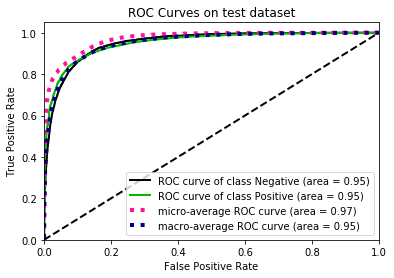

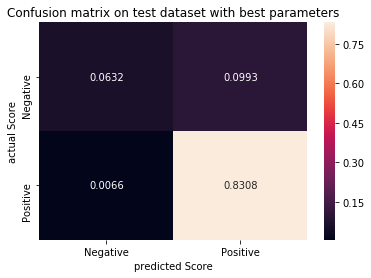

precission recall and f score using best optimal alpha predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.91      0.39      0.54      6501
    Positive       0.89      0.99      0.94     33499

   micro avg       0.89      0.89      0.89     40000
   macro avg       0.90      0.69      0.74     40000
weighted avg       0.90      0.89      0.88     40000

Wall time: 55.5 s


In [67]:
%%time
tfidf_feature_log_probs = mnb_model(x_train=tfidf_xtrain_vect, y_train=train_df.Score, x_cv=tfidf_xcv_vect, y_cv=cv_df.Score, x_test=tfidf_xtest_vect, y_test=test_df.Score)

## Observation:
1. We are getting an AUC score of  0.949 on validation data set and 0.951 AUC score on test datset with optimal alpha of 0.4275991609870157 using Multinomial Naive bayes algorithm and Bag of words unigram vectorizer.
2. There is a increase of 1.2% of AUC score by using TFIDF bigrams, rather than BOW unigrams
3. Clearly from the above figures and AUC scores we can say that our model is not over fitting, infact we got better AUC score on test dataset compared to validation dataset.
4. TFIDF bigram model predicted only 9.93% negative reviews as positive reviews, compared to 3.07% of BOW bigrams. 
5. So by using TFIDF bigrams false positive rate is more by 6.86% compared to BOW bigrams
6. our model predicted only 0.06% positive reviews as negative reviews compared to 6.78% of BOW bigrams.
7. So by using TFIDF bigrams false negative rate has decreased by 6.72%, which is good.
8. recall value on negative reviews is 39% compared to 81% of BOW bigrams, whereas recall value on positive reviews is 99% compared to 92% of BOW bigrams, so our TFIDF model is using most of the actual values from positive reviews compared to negative reviews. 
9. So TFIDF bigram model has decreased the recall rate on negative reviews by 42%, and increased the recall rate on positive reviews by 7%.
10. TFIDF bigram is better than TFIDF unigram in negative reviews recall value, but definitely not better than BOW bigrams.
11. Even though recall on positive rate is increased to 99% we can't say TFIDF is good model, as recall on negative reviews is only 42% compared to 81% of BOW bigrams, 
12. TFIDF model is less precise(89% precision) in predicting positive reviews than comapared to negative reivews(91% precision)
13. Eventhough TFIDF bigram model has better AUC score and better recall value on psoitive reviews, I am not considering it as best model when compared to BOW bigram model as BOW bigram model recall value on negative reviews is high.
14. So from the above analysis we can say that still BOW bigram model is better when compared with TFIDF bigram model, but TFIDF bigram model is definitely better than TFIDF unigram model.

In [68]:
output.add_row(['TFIDF bigram', 'Multinomial Naive bayes', 'NO', 'alpha = 0.4275991609870157', 0.951, 0.89])

### [5.5.1] Top 10 important features of positive class from TFIDF<font color='red'> SET 2</font>

In [69]:
sorted(zip(tfidf_feature_log_probs[1], tfidf.get_feature_names()), reverse=True)[:10]

[(-5.4132220991727, 'great'),
 (-5.415868347981499, 'love'),
 (-5.442131224334561, 'tea'),
 (-5.470779055022247, 'tast'),
 (-5.474544788057344, 'like'),
 (-5.477077460142615, 'good'),
 (-5.503300013609763, 'not'),
 (-5.552618547024011, 'flavor'),
 (-5.6054334500108425, 'coffe'),
 (-5.625623483866616, 'use')]

### [5.5.2] Top 10 important features of negative class from TFIDF<font color='red'> SET 2</font>

In [70]:
sorted(zip(tfidf_feature_log_probs[0], tfidf.get_feature_names()), reverse=True)[:10]

[(-4.800348249280464, 'not'),
 (-5.153086922026262, 'tast'),
 (-5.285175461468155, 'like'),
 (-5.293507184214786, 'product'),
 (-5.6175263734099, 'would'),
 (-5.6395148943364175, 'one'),
 (-5.657638088633988, 'flavor'),
 (-5.678275706767028, 'coffe'),
 (-5.717852736266671, 'veri'),
 (-5.752055059672411, 'order')]

## [5.6] Applying Naive Bayes on TFIDF trigram,<font color='red'> SET 2</font>

------------------------------------------------------------
started finding the optimal alpha for MultinomialNB algorithm
as of now best alpha is 5.000000000000007e-05 with AUC score of 0.94695650467857
as of now best alpha is 0.00013673078900308913 with AUC score of 0.9473011333502319
as of now best alpha is 0.00037390617322814436 with AUC score of 0.9476322661121479
as of now best alpha is 0.0010224897215721964 with AUC score of 0.9479536756224103
as of now best alpha is 0.0027961165275623007 with AUC score of 0.9482574429441051
as of now best alpha is 0.007646304379163406 with AUC score of 0.9485433903795688
as of now best alpha is 0.02090970461441573 with AUC score of 0.9488195234363717
as of now best alpha is 0.057180008195011796 with AUC score of 0.9491091478465705
as of now best alpha is 0.15636535271414095 with AUC score of 0.9493957058329815
as of now best alpha is 0.4275991609870157 with AUC score of 0.9494932618503928


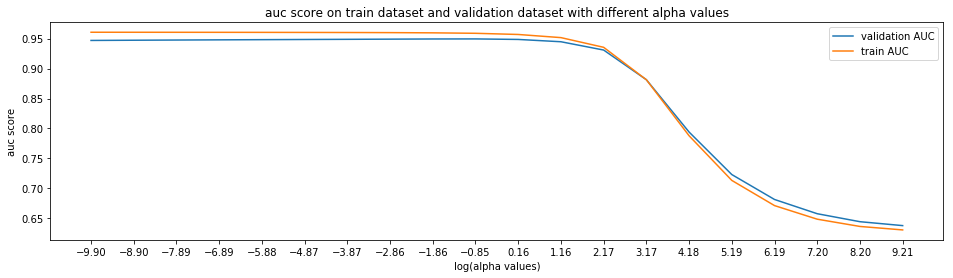

alpha value which is giving highest AUC value of 0.9494932618503928 on cross vadiation dataset is 0.4275991609870157
ROC plot with best alpha value on cross validation dataset


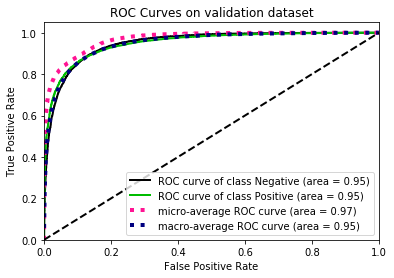

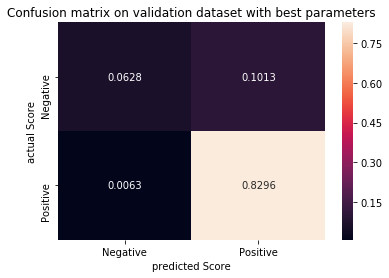

precission recall and f score on best optimal alpha predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.91      0.38      0.54      6564
    Positive       0.89      0.99      0.94     33436

   micro avg       0.89      0.89      0.89     40000
   macro avg       0.90      0.69      0.74     40000
weighted avg       0.89      0.89      0.87     40000

------------------------------------------------------------------------------
training the algoritm using train data + validation data and predicting on the test dataset
AUC score on test data is 0.9514769142355571


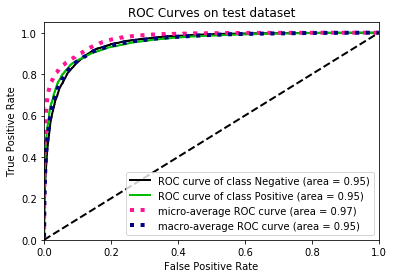

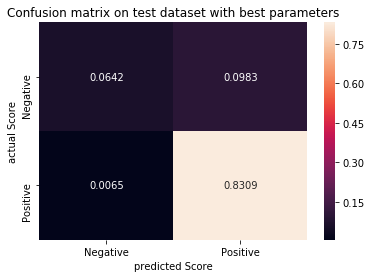

precission recall and f score using best optimal alpha predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.91      0.40      0.55      6501
    Positive       0.89      0.99      0.94     33499

   micro avg       0.90      0.90      0.90     40000
   macro avg       0.90      0.69      0.75     40000
weighted avg       0.90      0.90      0.88     40000

Wall time: 49.8 s


In [71]:
%%time
tfidf_tri_feature_log_probs = mnb_model(x_train=tfidf_tri_xtrain_vect, y_train=train_df.Score, x_cv=tfidf_tri_xcv_vect, y_cv=cv_df.Score, x_test=tfidf_tri_xtest_vect, y_test=test_df.Score)

## Observation:
1. We can see that except recall on negative reviews(which is 40% compared to 39% of TFIDF bigrams), every other value, test auc score, optimal alpha and micro avg f1 score of TFIDF Trigrams are same as TFIDF bigram values. which is similar to BOW bigrams and BOW trigrams
2. So all the observations done on TFIDF bigrams applies for TFIDF trigrams also, except recall on negative reviews is increased by 1%.

In [72]:
output.add_row(['TFIDF trigram', 'Multinomial Naive bayes', 'NO', 'alpha = 0.4275991609870157', 0.951, 0.90])

# [6.1] Feature Engineering

In [73]:
print(output)

+---------------+-------------------------+--------------------+----------------------------+----------+-------------------------+
|   Vectorizer  |          Model          | Feature engineered |      Hyper Parameter       | Test AUC | Test micro avg F1-score |
+---------------+-------------------------+--------------------+----------------------------+----------+-------------------------+
|  BOW unigram  | Multinomial Naive bayes |         NO         | alpha = 1.169319413176268  |  0.917   |           0.89          |
|   BOW bigram  | Multinomial Naive bayes |         NO         | alpha = 0.4275991609870157 |  0.939   |           0.9           |
|  BOW trigram  | Multinomial Naive bayes |         NO         | alpha = 0.4275991609870157 |  0.939   |           0.9           |
| TFIDF unigram | Multinomial Naive bayes |         NO         | alpha = 0.4275991609870157 |  0.927   |           0.87          |
|  TFIDF bigram | Multinomial Naive bayes |         NO         | alpha = 0.42759916

#### Till Now we can see that we have a best AUC score for TFIDF trigrams and TFIDF Bigrams of 0.951 except that recall rate is 1% more in TFIDF trigrams(40%) than TFIDF bigrams(39%)

#### But we also have the second best AUC score of 0.939 on BOW bigrams with a recall rate of 81% on negative reviews, which is 41% better than TFIDF trigrams(recall values of 41%). But in TFIDF trigrams precision on negative reviews is 91% compared to 61% precision in BOW bigrams, so it is a tradeoff between precison and recall values between these two values.

#### So I am considering as of now both the BOW bigrams and TFIDF trigrams as best model for our analysis. 

### lets see whether we can improve our model performance(both on BOW bigrams and TFIDF trigrams) by doing some feature engineering like

1. using the length of text review as one of the feature
2. also using the summary column as additional features to our text corpus

In [74]:
amazon_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_summary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,Positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,Positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,Positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,Positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


# [6.1.1] Feature Engineering by adding length of the Text column as one of the feature

In [75]:
# Now lets add length of every text review as one of the feature of the dataset
amazon_df['Text_length'] = [len(x) for x in amazon_df.Text]

### Now lets add this text_lenght column to BOW bigram_vectors and reapply our mnb model and check wether it is increasing our performance of our model </b>

In [80]:
len_bigram_xtrain_vect = sparse.hstack((bigram_xtrain_vect, np.array(amazon_df.Text_length[:120000])[:,None]))
len_bigram_xcv_vect = sparse.hstack((bigram_xcv_vect, np.array(amazon_df.Text_length[120000:160000])[:,None]))
len_bigram_xtest_vect = sparse.hstack((bigram_xtest_vect, np.array(amazon_df.Text_length[160000:200000])[:,None]))

In [82]:
len_bigram_xtrain_vect = len_bigram_xtrain_vect.tocsr()
len_bigram_xcv_vect = len_bigram_xcv_vect.tocsr()
len_bigram_xtest_vect = len_bigram_xtest_vect.tocsr()

In [83]:
print(bigram_xtrain_vect.shape, bigram_xcv_vect.shape, bigram_xtest_vect.shape)
print(len_bigram_xtrain_vect.shape, len_bigram_xcv_vect.shape, len_bigram_xtest_vect.shape)

(120000, 10000) (40000, 10000) (40000, 10000)
(120000, 10001) (40000, 10001) (40000, 10001)


<b> so now we have added len of the text column as another column to our train, cv , test corpuses, Now lets apply our mnb_model and see if there is any improvement in the performance </b>

------------------------------------------------------------
started finding the optimal alpha for MultinomialNB algorithm
as of now best alpha is 5.000000000000007e-05 with AUC score of 0.9345309932610485
as of now best alpha is 0.00013673078900308913 with AUC score of 0.9348529677587546
as of now best alpha is 0.00037390617322814436 with AUC score of 0.9351760243896695
as of now best alpha is 0.0010224897215721964 with AUC score of 0.9354824252818685
as of now best alpha is 0.0027961165275623007 with AUC score of 0.9357645066540576
as of now best alpha is 0.007646304379163406 with AUC score of 0.9360170400942063
as of now best alpha is 0.02090970461441573 with AUC score of 0.9362353712904292
as of now best alpha is 0.057180008195011796 with AUC score of 0.9364219561155662
as of now best alpha is 0.15636535271414095 with AUC score of 0.9365888825671046
as of now best alpha is 0.4275991609870157 with AUC score of 0.9367252700804011
as of now best alpha is 1.169319413176268 with AUC sco

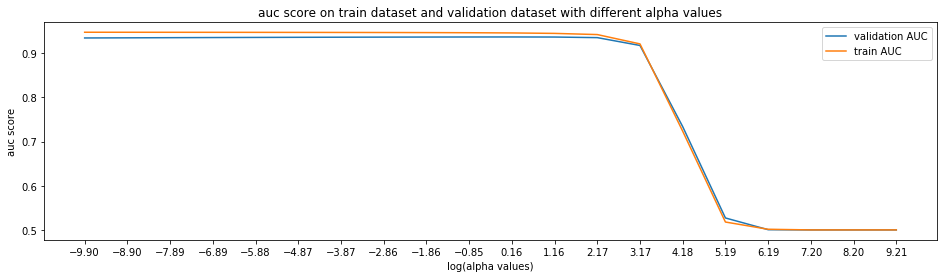

alpha value which is giving highest AUC value of 0.9368028988995429 on cross vadiation dataset is 1.169319413176268
ROC plot with best alpha value on cross validation dataset


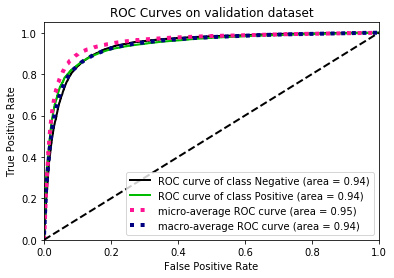

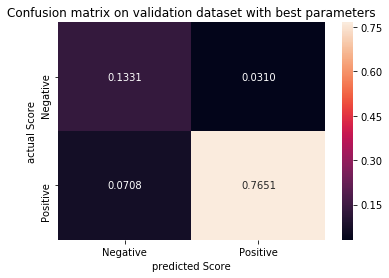

precission recall and f score on best optimal alpha predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.65      0.81      0.72      6564
    Positive       0.96      0.92      0.94     33436

   micro avg       0.90      0.90      0.90     40000
   macro avg       0.81      0.86      0.83     40000
weighted avg       0.91      0.90      0.90     40000

------------------------------------------------------------------------------
training the algoritm using train data + validation data and predicting on the test dataset
AUC score on test data is 0.9389277767575444


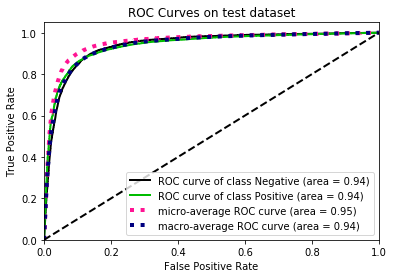

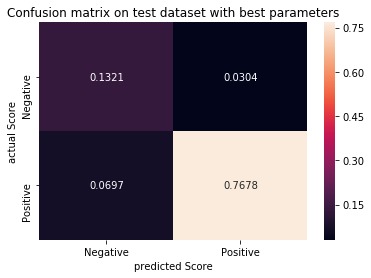

precission recall and f score using best optimal alpha predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.65      0.81      0.73      6501
    Positive       0.96      0.92      0.94     33499

   micro avg       0.90      0.90      0.90     40000
   macro avg       0.81      0.86      0.83     40000
weighted avg       0.91      0.90      0.90     40000

Wall time: 1min 36s


In [84]:
%%time
len_bigram_feature_log_probs = mnb_model(x_train=len_bigram_xtrain_vect, y_train=train_df.Score, x_cv=len_bigram_xcv_vect, y_cv=cv_df.Score, x_test=len_bigram_xtest_vect, y_test=test_df.Score)

## Observation: 
1. After adding the length of text as another feature the AUC scores and micro average F1 scores of BOW bigrams are almost same, and the performance didn't improve

### Now lets apply length of text column to TFIDF trigrams</b>

In [86]:
# Now lets add this text_lenght column to BOW bigram_vectors and reapply our mnb model
# and check wether it is increasing our performance of our model
len_tfidf_trigram_xtrain_vect = sparse.hstack((tfidf_tri_xtrain_vect, np.array(amazon_df.Text_length[:120000])[:,None]))
len_tfidf_trigram_xcv_vect = sparse.hstack((tfidf_tri_xcv_vect, np.array(amazon_df.Text_length[120000:160000])[:,None]))
len_tfidf_trigram_xtest_vect = sparse.hstack((tfidf_tri_xtest_vect, np.array(amazon_df.Text_length[160000:200000])[:,None]))

In [87]:
len_tfidf_trigram_xtrain_vect = len_tfidf_trigram_xtrain_vect.tocsr()
len_tfidf_trigram_xcv_vect = len_tfidf_trigram_xcv_vect.tocsr()
len_tfidf_trigram_xtest_vect = len_tfidf_trigram_xtest_vect.tocsr()

------------------------------------------------------------
started finding the optimal alpha for MultinomialNB algorithm
as of now best alpha is 5.000000000000007e-05 with AUC score of 0.9376489607620959
as of now best alpha is 0.00013673078900308913 with AUC score of 0.9378926024845303
as of now best alpha is 0.00037390617322814436 with AUC score of 0.9381244751540029
as of now best alpha is 0.0010224897215721964 with AUC score of 0.938341986207162
as of now best alpha is 0.0027961165275623007 with AUC score of 0.9385435318086839
as of now best alpha is 0.007646304379163406 with AUC score of 0.9387474239306374
as of now best alpha is 0.02090970461441573 with AUC score of 0.9390007296721709
as of now best alpha is 0.057180008195011796 with AUC score of 0.9394444134005107
as of now best alpha is 0.15636535271414095 with AUC score of 0.9404610764111618
as of now best alpha is 0.4275991609870157 with AUC score of 0.9431900341099322
as of now best alpha is 1.169319413176268 with AUC scor

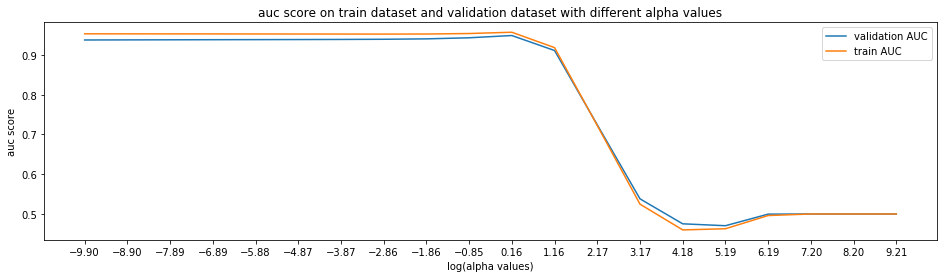

alpha value which is giving highest AUC value of 0.9488676886159548 on cross vadiation dataset is 1.169319413176268
ROC plot with best alpha value on cross validation dataset


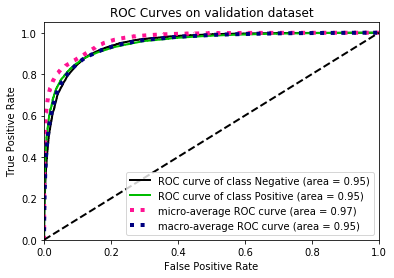

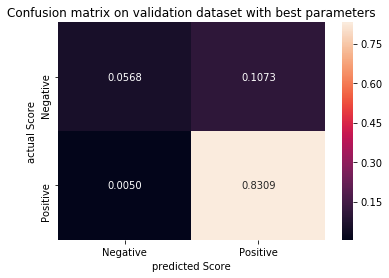

precission recall and f score on best optimal alpha predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.92      0.35      0.50      6564
    Positive       0.89      0.99      0.94     33436

   micro avg       0.89      0.89      0.89     40000
   macro avg       0.90      0.67      0.72     40000
weighted avg       0.89      0.89      0.87     40000

------------------------------------------------------------------------------
training the algoritm using train data + validation data and predicting on the test dataset
AUC score on test data is 0.9501713585464552


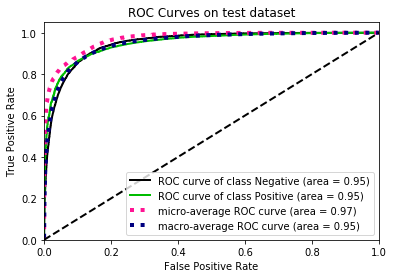

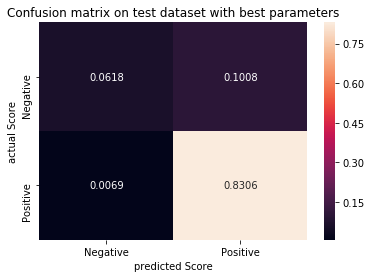

precission recall and f score using best optimal alpha predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.90      0.38      0.53      6501
    Positive       0.89      0.99      0.94     33499

   micro avg       0.89      0.89      0.89     40000
   macro avg       0.90      0.69      0.74     40000
weighted avg       0.89      0.89      0.87     40000

Wall time: 53.5 s


In [88]:
%%time
len_tfidf_trigram_feature_log_probs = mnb_model(x_train=len_tfidf_trigram_xtrain_vect, y_train=train_df.Score, x_cv=len_tfidf_trigram_xcv_vect, y_cv=cv_df.Score, x_test=len_tfidf_trigram_xtest_vect, y_test=test_df.Score)

## observation:
1. AUC Score is almost same and have no improvement, but after adding the lenghth of text column the recall rate of negative reviews has decreased by 2% 0.40 to 0.38
2. So we can conclude that adding the length of the text reviews as a separate feature is not helping our model performance.

# [6.1.2] Feature Engineering by adding summary column words as additional features to our text corputs

### Bag of Words bigrams feature engineering
Now lets convert the summary column words to vectors using BOW bigrams and add these feature vectors to Text column corpus and reapply our mnb model and check wether it is increasing our performance of our model </b>

In [89]:
bigram_summary = CountVectorizer(ngram_range=(1,2), min_df=50)
bigram_summary_xtrain = bigram_summary.fit_transform(train_df.Cleaned_summary)
bigram_summary_xcv = bigram_summary.transform(cv_df.Cleaned_summary)
bigram_summary_xtest = bigram_summary.transform(test_df.Cleaned_summary)

In [90]:
print(bigram_summary_xtrain.shape, bigram_summary_xcv.shape, bigram_summary_xtest.shape)

(120000, 1193) (40000, 1193) (40000, 1193)


In [91]:
# adding summary vectors to Text vectors 
bigram_train_text_summ = sparse.hstack((bigram_xtrain_vect, bigram_summary_xtrain)).tocsr()
bigram_cv_text_summ = sparse.hstack((bigram_xcv_vect, bigram_summary_xcv)).tocsr()
bigram_test_text_summ = sparse.hstack((bigram_xtest_vect, bigram_summary_xtest)).tocsr()

In [93]:
print(bigram_xtrain_vect.shape, bigram_xcv_vect.shape, bigram_xtest_vect.shape)
print(bigram_train_text_summ.shape, bigram_cv_text_summ.shape, bigram_test_text_summ.shape)

(120000, 10000) (40000, 10000) (40000, 10000)
(120000, 11193) (40000, 11193) (40000, 11193)


we have added the summary vectors to text vectors lets apply mnb_model and see whether the performance has increased or not

------------------------------------------------------------
started finding the optimal alpha for MultinomialNB algorithm
as of now best alpha is 5.000000000000007e-05 with AUC score of 0.9556854285509953
as of now best alpha is 0.00013673078900308913 with AUC score of 0.9560056169593631
as of now best alpha is 0.00037390617322814436 with AUC score of 0.9563093273266784
as of now best alpha is 0.0010224897215721964 with AUC score of 0.9565932107354322
as of now best alpha is 0.0027961165275623007 with AUC score of 0.956836508453415
as of now best alpha is 0.007646304379163406 with AUC score of 0.9570449500911963
as of now best alpha is 0.02090970461441573 with AUC score of 0.9572135920086426
as of now best alpha is 0.057180008195011796 with AUC score of 0.9573404932005037
as of now best alpha is 0.15636535271414095 with AUC score of 0.9574121213062305
as of now best alpha is 0.4275991609870157 with AUC score of 0.9574140714241817


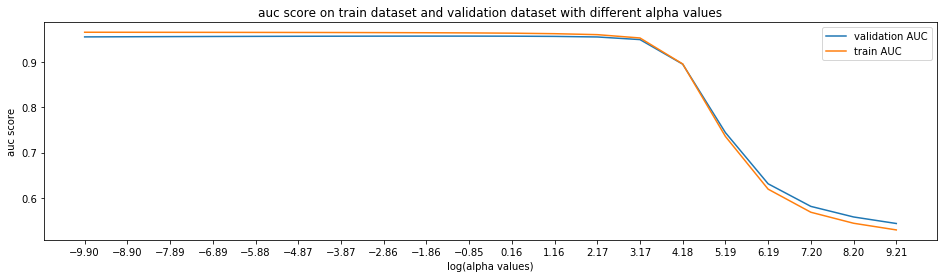

alpha value which is giving highest AUC value of 0.9574140714241817 on cross vadiation dataset is 0.4275991609870157
ROC plot with best alpha value on cross validation dataset


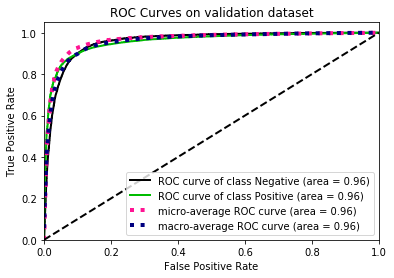

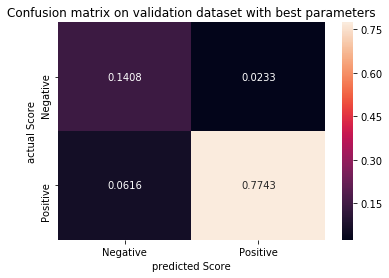

precission recall and f score on best optimal alpha predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.70      0.86      0.77      6564
    Positive       0.97      0.93      0.95     33436

   micro avg       0.92      0.92      0.92     40000
   macro avg       0.83      0.89      0.86     40000
weighted avg       0.93      0.92      0.92     40000

------------------------------------------------------------------------------
training the algoritm using train data + validation data and predicting on the test dataset
AUC score on test data is 0.9589839283256907


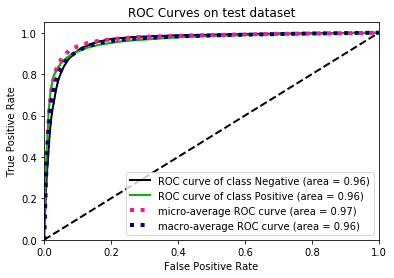

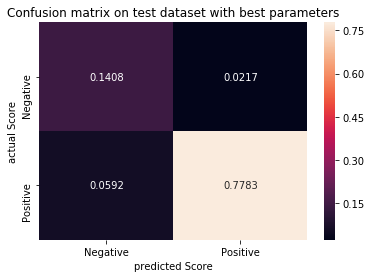

precission recall and f score using best optimal alpha predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.70      0.87      0.78      6501
    Positive       0.97      0.93      0.95     33499

   micro avg       0.92      0.92      0.92     40000
   macro avg       0.84      0.90      0.86     40000
weighted avg       0.93      0.92      0.92     40000

Wall time: 1min 12s


In [94]:
%%time
fe_bigram_text_summ_feature_log_probs = mnb_model(x_train=bigram_train_text_summ, y_train=train_df.Score, x_cv=bigram_cv_text_summ, y_cv=cv_df.Score, x_test=bigram_test_text_summ, y_test=test_df.Score)

## observation:
1. Great AUC Score has increased from 0.939 to 0.9589 after adding summary column features
2. Infact after feature engineering with summary column we get better AUC score than TFIDF trigrams without feature engineering
2. Recall rate on negative reviews has increased from 0.81 to 0.87 after after adding summary column features
3. Precision on negative reviews has increased from 0.66 to 0.70
4. So overall micro avg F1 score has increased from 0.90 to 0.92, which is quite good.

In [104]:
output.add_row(['BOW bigrams', 'Multinomial Naive bayes', 'YES(summary)', 'alpha = 0.4275991609870157', 0.9589, 0.92])

### TFIDF trigram FEATURE ENGINEERING
Now lets convert the summary column words to vectors using TFIDF trigrams and add these feature vectors to Text column corpus and reapply our mnb model and check wether it is increasing our performance of our model </b>

In [97]:
tfidf_trigram_summary = TfidfVectorizer(ngram_range=(1,3), min_df=50)
tfidf_trigram_summary_xtrain = tfidf_trigram_summary.fit_transform(train_df.Cleaned_summary)
tfidf_trigram_summary_xcv = tfidf_trigram_summary.transform(cv_df.Cleaned_summary)
tfidf_trigram_summary_xtest = tfidf_trigram_summary.transform(test_df.Cleaned_summary)

In [98]:
tfidf_trigram_train_text_summ = sparse.hstack((tfidf_tri_xtrain_vect, tfidf_trigram_summary_xtrain)).tocsr()
tfidf_trigram_cv_text_summ = sparse.hstack((tfidf_tri_xcv_vect, tfidf_trigram_summary_xcv)).tocsr()
tfidf_trigram_test_text_summ = sparse.hstack((tfidf_tri_xtest_vect, tfidf_trigram_summary_xtest)).tocsr()

------------------------------------------------------------
started finding the optimal alpha for MultinomialNB algorithm
as of now best alpha is 5.000000000000007e-05 with AUC score of 0.9655688905957585
as of now best alpha is 0.00013673078900308913 with AUC score of 0.965771994469101
as of now best alpha is 0.00037390617322814436 with AUC score of 0.9659884712307301
as of now best alpha is 0.0010224897215721964 with AUC score of 0.9662192959396212
as of now best alpha is 0.0027961165275623007 with AUC score of 0.9664621949769482
as of now best alpha is 0.007646304379163406 with AUC score of 0.9667171728990613
as of now best alpha is 0.02090970461441573 with AUC score of 0.9669629105426584
as of now best alpha is 0.057180008195011796 with AUC score of 0.9671785899429756
as of now best alpha is 0.15636535271414095 with AUC score of 0.9673095440084759


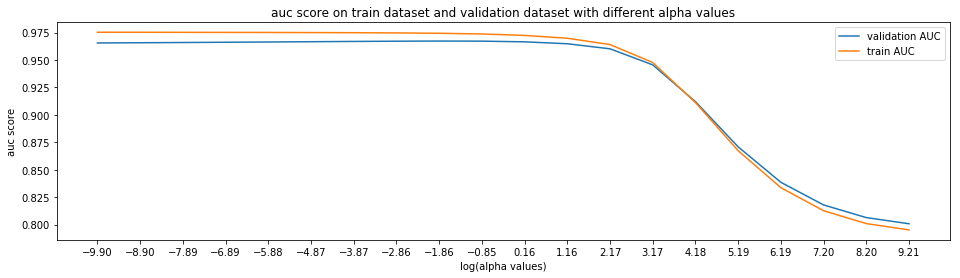

alpha value which is giving highest AUC value of 0.9673095440084759 on cross vadiation dataset is 0.15636535271414095
ROC plot with best alpha value on cross validation dataset


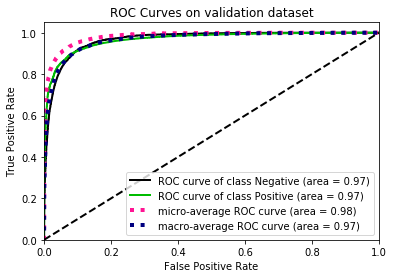

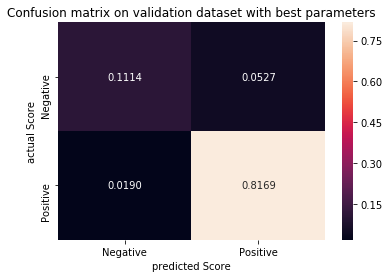

precission recall and f score on best optimal alpha predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.85      0.68      0.76      6564
    Positive       0.94      0.98      0.96     33436

   micro avg       0.93      0.93      0.93     40000
   macro avg       0.90      0.83      0.86     40000
weighted avg       0.93      0.93      0.92     40000

------------------------------------------------------------------------------
training the algoritm using train data + validation data and predicting on the test dataset
AUC score on test data is 0.9697350132003609


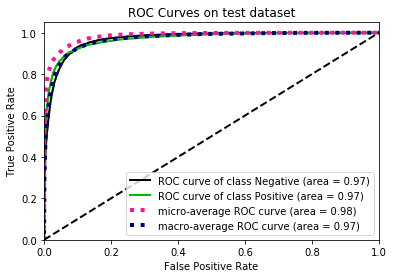

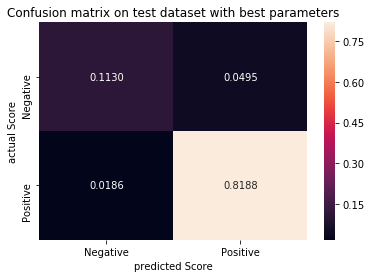

precission recall and f score using best optimal alpha predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.86      0.70      0.77      6501
    Positive       0.94      0.98      0.96     33499

   micro avg       0.93      0.93      0.93     40000
   macro avg       0.90      0.84      0.86     40000
weighted avg       0.93      0.93      0.93     40000

Wall time: 54.2 s


In [99]:
%%time
fe_tfidf_trigram_text_summ_feature_log_probs = mnb_model(x_train=tfidf_trigram_train_text_summ, y_train=train_df.Score, x_cv=tfidf_trigram_cv_text_summ, y_cv=cv_df.Score, x_test=tfidf_trigram_test_text_summ, y_test=test_df.Score)

## observation:
1. Great AUC Score has increased from 0.951 to 0.969 after adding summary column features
2. So after feature engineering on both TFIDF trigrams and BOW bigrams, TFIDF trigrams has best AUC score of 0.969
2. Recall rate on negative reviews has increased from 0.40 to 0.70 after adding summary column features, with a precision of 86%.
3. recall on positive reviews is 98% with precision of 94%.
4. So overall micro avg F1 score has increased from 0.90 to 0.93 after feature engineering, which is quite good.

In [117]:
output.add_row(['TFIDF trigrams', 'Multinomial Naive bayes', 'YES(summary)', 'alpha = 0.15636535271414095', 0.969, 0.93])

In [132]:
total_list = tfidf_tri.get_feature_names() + tfidf_trigram_summary.get_feature_names()
print(len(total_list), fe_tfidf_trigram_text_summ_feature_log_probs.shape)

11215 (2, 11215)


### [6.1.2.1] Top 20 important features of positive class from TFIDF trigram after feature engineering<font color='red'> SET 2</font>

In [133]:
sorted(zip(fe_tfidf_trigram_text_summ_feature_log_probs[1], total_list), reverse=True)[:20]

[(-4.870118420833368, 'great'),
 (-5.243135529774937, 'good'),
 (-5.294300467068254, 'love'),
 (-5.353872681337442, 'best'),
 (-5.5210593633630225, 'delici'),
 (-5.668008349967602, 'great'),
 (-5.670051771783173, 'love'),
 (-5.698401355646869, 'tea'),
 (-5.72694743534799, 'tast'),
 (-5.728551955317069, 'like'),
 (-5.732974375033679, 'good'),
 (-5.7571415620321975, 'not'),
 (-5.79362346560571, 'tea'),
 (-5.806556026629957, 'flavor'),
 (-5.860749949735832, 'coffe'),
 (-5.877621368185679, 'use'),
 (-5.897810543783927, 'product'),
 (-5.900049559899635, 'veri'),
 (-5.946503815094983, 'excel'),
 (-5.963642896618931, 'yummi')]

<b>we can see that the positive words like 'great good love best delici yummi excel' are in top log probabilities </b>

### [6.1.2.2] Top 20 important features of negative class from TFIDF trigram after feature engineering<font color='red'> SET 2</font>

In [134]:
sorted(zip(fe_tfidf_trigram_text_summ_feature_log_probs[0], total_list), reverse=True)[:20]

[(-4.462278828445973, 'not'),
 (-5.0096394395499715, 'not'),
 (-5.364365756442811, 'tast'),
 (-5.410618745568394, 'tast'),
 (-5.495847081215678, 'like'),
 (-5.501162569231009, 'product'),
 (-5.505712418253506, 'disappoint'),
 (-5.82859414289618, 'would'),
 (-5.847468330706474, 'one'),
 (-5.866993251959075, 'flavor'),
 (-5.8880323438932765, 'coffe'),
 (-5.927790544105772, 'veri'),
 (-5.9328203746571475, 'like'),
 (-5.958531908750009, 'order'),
 (-5.974880962760263, 'buy'),
 (-5.987545902747165, 'tri'),
 (-6.019394035125626, 'good'),
 (-6.058744445200294, 'box'),
 (-6.088981668287746, 'bad'),
 (-6.11980752269087, 'tea')]

<b>we can see that the negative words like ''not disappoint bad and neutral words like coffe order buy tea, and positive words like good like tast'' are also in top log probabilities </b>

In [118]:
print(output)

+----------------+-------------------------+--------------------+-----------------------------+----------+-------------------------+
|   Vectorizer   |          Model          | Feature engineered |       Hyper Parameter       | Test AUC | Test micro avg F1-score |
+----------------+-------------------------+--------------------+-----------------------------+----------+-------------------------+
|  BOW unigram   | Multinomial Naive bayes |         NO         |  alpha = 1.169319413176268  |  0.917   |           0.89          |
|   BOW bigram   | Multinomial Naive bayes |         NO         |  alpha = 0.4275991609870157 |  0.939   |           0.9           |
|  BOW trigram   | Multinomial Naive bayes |         NO         |  alpha = 0.4275991609870157 |  0.939   |           0.9           |
| TFIDF unigram  | Multinomial Naive bayes |         NO         |  alpha = 0.4275991609870157 |  0.927   |           0.87          |
|  TFIDF bigram  | Multinomial Naive bayes |         NO         |  al

# Conclusion:

1. Assumed every review with less than 3 rating as negative review and greater than 3 as positive review and stored in a column called Score
2. Performed Data wrangling by removing subduplicate observations and exploratory data analysis.
2. Converted each review as vectors using techniques like Bag Of Words Unigram Bigram, Trigram TFIDF unigram, bigram and trigram.
5. Reduced the dimensions of vectors using min_df and max_features values in the models. 
6. Used simple crossvalidation on the dimensional reduced data(70-30-30 split out of 2 lakshs dataet), and applied Multinomial Naive bayes algorithm on the vectorizers, found the optimal alpha using train and validation dataset.
7. Used the optimal K for training the model and predicted the class variables on the test dataset. Used the micro average f-score and AUC for model evaluation.(more preference is given recall value of negative reviews)
8. To perform the above steps written a function called mnb_model.
9. We are getting the best test AUC Score of 0.951 from TFIDF bigrams, and TFIDF trigrams.
10. Even though we are getting the best AUC score from TFIDF bigram and TFIDF trigram, the recall value of negative reviews is only 39% and 40% respectively.
10. We got the best micro average Test F1 score of mnb model in both TFIDF trigram and BOW bigram of 0.90
11. But we also have the second best AUC score of 0.939 on BOW bigrams with a recall rate of 81% on negative reviews, which is 41% better than TFIDF trigrams(recall values of 41%). But in TFIDF trigrams precision on negative reviews is 91% compared to 61% precision in BOW bigrams, so it is a tradeoff between precison and recall values between these two values.
12. After the above steps did feature engineering by adding length of text as one of the featues,
13. and also adding the features of sumamry column to text corpus and reappied our mnb_model 
14. Adding the length of the text as another feature didn't help in increasing the performance, instead it reduced the recall on negative review by 1% in case of TFID trigram.
15. but adding the summary column features has helped in increasing the performance of the model. infact it increased the recall on negative reviews and also AUC score of both the BOW bigrams and TFIDF trigrams.
16. So after featue engineering the problem of low recall rate on negative reviews by TFIDF trigrams was reduced, infact the recall rate on negative reviews has increased by 30%.
17. After feature engineering the overall micro f1-score of BOW bigrams has increased from 0.90 to 0.92 and TFIDF trigrams has increased from 0.90 to 0.93.
### 18. So after feature engineering TFIDF trigrams is the best model for predicting positive and negative reviews with AUC score of 0.969 and micr0 avg f1-score of 0.93 